In [1]:
from httpx import Client, AsyncClient
import os, sys
import json
import pandas as pd
from pprint import pprint

import httpx 
import pandas as pd
from typing import List, Dict, Any
import asyncio
import os
import json

# from eda.gtr_org_data_enrichment import *

# Move the current working directory to the root of the repository for consistency in file paths
def move_working_dir_to_repo_root(repo_name="orgsync"):
    """
    Move the current working directory to the root of the repository.
    """
    current_dir = os.getcwd()
    while os.path.basename(current_dir).lower() != repo_name:
        current_dir = os.path.dirname(current_dir)
    os.chdir(current_dir)
    print("Current working directory: ", os.getcwd())

move_working_dir_to_repo_root(repo_name="orgsync")

def pprint_first_row_for_column(df, column_name, i=0):
    print(f"First row for column '{column_name}':")
    pprint(df[column_name].iloc[i])
    return df[column_name].iloc[i]


data = os.path.join("data", "processed", "gtr_links_expanded.csv")
df = pd.read_csv(data)




Current working directory:  c:\Users\dec2g\GitHub\OrgSync


In [23]:


async def split_link(link):
    """
    Split link of form `http://gtr.ukri.org/gtr/api/<domain>/<id>` into domain and id.
    """
    base = "https://gtr.ukri.org/gtr/api"
    tail = link[len(base):]
    print(tail)
    domain, identifier = tail.split("/")
    print(f"link split: {tail}, {domain}, {identifier}")
    return domain, identifier

async def get_project_details(client, project_id):
    #! we could simplify and just pass the url, or make one generic getter than takes domain and href_id
    url = f"https://gtr.ukri.org/gtr/api/projects/{project_id}"
    print(f"url: {url}")
    response = await client.get(url)
    response.raise_for_status()
    # pprint(response.json())
    return response.json()

# async def get_person_details_from_project(client, )

async def get_person_details(client, person_id):
    url = f"https://gtr.ukri.org/gtr/api/persons/{person_id}"
    try: 
        print(f"url: {url} for person_id={person_id}")
        response = await client.get(url)
        response.raise_for_status()
        pprint(response.json())
        return response.json()
    except Exception as e:
        print(f"Error fetching person details for person_id={person_id}: {e}")
        return {}

async def fetch_person_names(client, links, rel_type):
    names = []
    print(f"Fetching names from links: {links}")
    for link in links:
        print(f"Fetching name from link: {link}")
        _, person_id = await split_link(link)
        person_details = await get_person_details(client, person_id)
        first_name = person_details.get('firstName', '')
        print(f"first_name: {first_name}")
        last_name = person_details.get('surname', '')
        print(f"last_name: {last_name}")
        other_names = person_details.get('otherNames', [])
        # full_name = f"{person_details.get('firstName', '')} {person_details.get('lastName', '')}".strip()
        names.append(f"{first_name} {last_name} {other_names}")
    print(f"fetched names: {names}")
    return names

async def process_item(client, row):
    rel = row["rel"]
    org_id = row["id"]
    print(f"Processing org {org_id}, rel={rel}")
    try:
        if rel == "PROJECT":
            print(f"Processing {rel} in row {row} for org_id={org_id}")
            project_url = row["href_link"]
            domain, project_id = await split_link(project_url)
            print(f"Fetching project details for project_id={project_id}, in domain={domain}")
            try:
                project_details = await get_project_details(client, project_id)
            except Exception as e:
                print(f"Error fetching project details for project_id={project_id}: {e}")
                return None
            pprint(project_details)
            # pprint(f"org_id = {org_id}, rel = {rel}, project_details = {project_details}")
            project_links_list = project_details["links"]["link"]
            pprint(f"project_links_list for project {project_id}: {project_links_list}")
            pi_links = [dict_i["href"] for dict_i in project_links_list if dict_i["rel"] == "PI_PER"]
            cois_links = [dict_i["href"] for dict_i in project_links_list if dict_i["rel"] == "COI_PER"]
            pprint(f"PI links for project {project_id}: {pi_links}")
            pprint(f"COI links for project {project_id}: {cois_links}")
            # try:
            pi_names = await fetch_person_names(client, pi_links, "PI_PER")
            # except Exception as e:
            #     print(f"Error fetching PI names for project {project_id}: {e}")

            # try:
            coi_names = await fetch_person_names(client, cois_links, "COI_PER")
            # except Exception as e:
            #     print(f"Error fetching COI names for project {project_id}: {e}")

            return {
                "org_id": org_id, 
                "rel": rel, 
                # "details": project_details,
                "project_id": project_id,
                "pi_names": pi_names,
                "coi_names": coi_names
                }
        
        elif rel == "EMPLOYEE":
            print("Skipping EMPLOYEE ROW")
            return None #! cut out employee for now
            person_url = row["href_link"]
            domain, person_id = await split_link(person_url)
            print(f"Fetching person details for person_id={person_id}, in domain={domain}")
            person_details = await get_person_details(client, person_id)
            # pprint(f"org_id = {org_id}, rel = {rel}, person_details = {person_details}")
            return {"org_id": org_id, "rel": rel, "details": person_details}
        
        else:
            print(f"Unknown rel: {rel}")
            return None

    except httpx.HTTPStatusError as e:
        print(f"HTTP error occurred while processing org {org_id}, rel={rel}: {e}")
    # except Exception as e:
    #     print(f"Error processing org {org_id}, rel={rel}: {e}")
    return None

# async def process_project(client, project_json):


async def process_data(df):
    async_client = httpx.AsyncClient(
            headers={"accept": "application/vnd.rcuk.gtr.json-v7"},
            base_url="https://gtr.ukri.org/gtr/api/",
            follow_redirects=True,
            timeout=20,
        )
    async with async_client as client:
        tasks = [process_item(client, row) for _, row in df.iterrows()]
        results = await asyncio.gather(*tasks)
    return [result for result in results if result is not None]

async def main(df):
    pprint(df)
    enriched_data = await process_data(df)
    enriched_df = pd.DataFrame(enriched_data)
    result_df = df.merge(enriched_df, left_on=['id', 'href_link'], right_on=['org_id', 'project_id'], how='left')
    # print("Processing complete")
    # pprint(enriched_data)
    result_df['pi_names'] = result_df['pi_names'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
    result_df['coi_names'] = result_df['coi_names'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
    return enriched_data, enriched_df

my_id = pprint_first_row_for_column(df, "id")

# get all rows with id = my_id
df_id = df[df["id"] == my_id]
df_id = df_id[df_id["rel"] == "PROJECT"]

# get only first 3 rows
df_id = df_id.head(3)

# df_id.head()

enriched_data, enriched_df = await main(df_id)


First row for column 'id':
'5331B126-3AB4-4412-B56D-00E8F2796556'
                                     id  \
0  5331B126-3AB4-4412-B56D-00E8F2796556   
1  5331B126-3AB4-4412-B56D-00E8F2796556   
2  5331B126-3AB4-4412-B56D-00E8F2796556   

                                            href_org  \
0  http://gtr.ukri.org/gtr/api/organisations/5331...   
1  http://gtr.ukri.org/gtr/api/organisations/5331...   
2  http://gtr.ukri.org/gtr/api/organisations/5331...   

                                               links  \
0  {'href': 'http://gtr.ukri.org/gtr/api/projects...   
1  {'href': 'http://gtr.ukri.org/gtr/api/projects...   
2  {'href': 'http://gtr.ukri.org/gtr/api/projects...   

                                           href_link      rel  start  end  
0  http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-...  PROJECT    NaN  NaN  
1  http://gtr.ukri.org/gtr/api/projects/0D0F72CC-...  PROJECT    NaN  NaN  
2  http://gtr.ukri.org/gtr/api/projects/0C6849FD-...  PROJECT    NaN  NaN  
Process

In [25]:
enriched_df.head()

,org_id,rel,project_id,pi_names,coi_names
0,5331B126-3AB4-4412-B56D-00E8F2796556,PROJECT,0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906,[Matthew ],[Uracha ]
1,5331B126-3AB4-4412-B56D-00E8F2796556,PROJECT,0D0F72CC-0163-47CE-A462-5FDDBA4C1C38,[Patrick ],[Stuart ]
2,5331B126-3AB4-4412-B56D-00E8F2796556,PROJECT,0C6849FD-CA2D-49A9-80D4-75F710980208,[Maria ],"[Amir , Charlotte , Sara , Harald , J , S..."


In [21]:
enriched_data

[{'org_id': '5331B126-3AB4-4412-B56D-00E8F2796556',
  'rel': 'PROJECT',
  'project_id': '0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906',
  'pi_names': ['Matthew  '],
  'coi_names': ['Uracha  ']},
 {'org_id': '5331B126-3AB4-4412-B56D-00E8F2796556',
  'rel': 'PROJECT',
  'project_id': '0D0F72CC-0163-47CE-A462-5FDDBA4C1C38',
  'pi_names': ['Patrick  '],
  'coi_names': ['Stuart  ']},
 {'org_id': '5331B126-3AB4-4412-B56D-00E8F2796556',
  'rel': 'PROJECT',
  'project_id': '0C6849FD-CA2D-49A9-80D4-75F710980208',
  'pi_names': ['Maria  '],
  'coi_names': ['Amir  ',
   'Charlotte  ',
   'Sara  ',
   'Harald  ',
   'J  ',
   'Suzanne  ']}]

In [4]:
pprint(enriched_data)

[]


# Test of dataframe enrichement with PI and COI names only


In [8]:
my_id = pprint_first_row_for_column(df, "id")

# get all rows with id = my_id
df_id = df[df["id"] == my_id]

df_id.head()




First row for column 'id':
'5331B126-3AB4-4412-B56D-00E8F2796556'


,id,href_org,links,href_link,rel,start,end
0,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-...,PROJECT,NaN,NaN
1,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0D0F72CC-...,PROJECT,NaN,NaN
2,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0C6849FD-...,PROJECT,NaN,NaN
3,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/C4059685-...,PROJECT,NaN,NaN
4,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/F0E04953-...,PROJECT,NaN,NaN


In [11]:
async def split_link(link):
    base = "https://gtr.ukri.org/gtr/api"
    tail = link[len(base):]
    domain, identifier = tail.lstrip('/').split("/", 1)
    return domain, identifier

async def get_project_details(client, project_id):
    url = f"projects/{project_id}"
    response = await client.get(url)
    response.raise_for_status()
    return response.json()

async def get_person_details(client, person_id):
    url = f"persons/{person_id}"
    response = await client.get(url)
    response.raise_for_status()
    return response.json()

async def fetch_person_names(client, links, rel_type):
    names = []
    for link in links:
        if link['rel'] == rel_type:
            _, person_id = await split_link(link['href'])
            person_details = await get_person_details(client, person_id)
            full_name = f"{person_details.get('firstName', '')} {person_details.get('lastName', '')}".strip()
            names.append(full_name)
    return names

async def process_item(client, row):
    rel = row["rel"]
    org_id = row["id"]
    print(f"Processing org {org_id}, rel={rel}")
    try:
        if rel == "PROJECT":
            project_url = row["href_link"]
            _, project_id = await split_link(project_url)
            print(f"Fetching project details for project_id={project_id}")
            project_details = await get_project_details(client, project_id)
            
            # Fetch PI and COI names
            pi_names = await fetch_person_names(client, project_details['links']['link'], 'PI_PER')
            coi_names = await fetch_person_names(client, project_details['links']['link'], 'COI_PER')
            
            return {
                "org_id": org_id,
                "project_id": project_id,
                "project_title": project_details.get('title', ''),
                "pi_names": pi_names,
                "coi_names": coi_names
            }
        else:
            return None

    except httpx.HTTPStatusError as e:
        print(f"HTTP error occurred while processing org {org_id}, rel={rel}: {e}")
    except Exception as e:
        print(f"Error processing org {org_id}, rel={rel}: {e}")
    return None

async def process_data(df_id):
    async_client = httpx.AsyncClient(
        headers={"accept": "application/vnd.rcuk.gtr.json-v7"},
        base_url="https://gtr.ukri.org/gtr/api/",
        follow_redirects=True,
        timeout=20,
    )
    async with async_client as client:
        tasks = [process_item(client, row) for _, row in df_id.iterrows()]
        results = await asyncio.gather(*tasks)
    return [result for result in results if result is not None]

async def main(df):
    enriched_data = await process_data(df)
    
    # Convert the enriched data to a DataFrame
    enriched_df = pd.DataFrame(enriched_data)
    
    # Merge the enriched data with the original DataFrame
    result_df = df.merge(enriched_df, left_on=['id', 'href_link'], right_on=['org_id', 'project_id'], how='left')
    
    # Clean up the result DataFrame
    result_df = result_df.drop(columns=['org_id', 'project_id'])
    result_df['pi_names'] = result_df['pi_names'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
    result_df['coi_names'] = result_df['coi_names'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
    
    return result_df

# Assuming df_id is your original DataFrame
enriched_df = await main(df_id)
print(enriched_df.head())

Processing org 5331B126-3AB4-4412-B56D-00E8F2796556, rel=PROJECT
Fetching project details for project_id=0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906
                                     id  \
0  5331B126-3AB4-4412-B56D-00E8F2796556   

                                            href_org  \
0  http://gtr.ukri.org/gtr/api/organisations/5331...   

                                               links  \
0  {'href': 'http://gtr.ukri.org/gtr/api/projects...   

                                           href_link      rel  start  end  \
0  http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-...  PROJECT    NaN  NaN   

  project_title pi_names coi_names  
0           NaN                     


In [10]:
enriched_df.head()

,id,href_org,links,href_link,rel,start,end,project_title,pi_names,coi_names
0,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-...,PROJECT,NaN,NaN,NaN,,
1,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0D0F72CC-...,PROJECT,NaN,NaN,NaN,,
2,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0C6849FD-...,PROJECT,NaN,NaN,NaN,,
3,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/C4059685-...,PROJECT,NaN,NaN,NaN,,
4,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/F0E04953-...,PROJECT,NaN,NaN,NaN,,


### Test enrichment on first organisation in dataset

In [11]:
my_id = pprint_first_row_for_column(df, "id")

# get all rows with id = my_id
df_id = df[df["id"] == my_id]

df_id.head()

First row for column 'id':
'5331B126-3AB4-4412-B56D-00E8F2796556'


,id,href_org,links,href_link,rel,start,end
0,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-...,PROJECT,NaN,NaN
1,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0D0F72CC-...,PROJECT,NaN,NaN
2,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0C6849FD-...,PROJECT,NaN,NaN
3,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/C4059685-...,PROJECT,NaN,NaN
4,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/F0E04953-...,PROJECT,NaN,NaN


In [12]:
pprint(df_id.iloc[0].to_dict())

{'end': nan,
 'href_link': 'http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906',
 'href_org': 'http://gtr.ukri.org/gtr/api/organisations/5331B126-3AB4-4412-B56D-00E8F2796556',
 'id': '5331B126-3AB4-4412-B56D-00E8F2796556',
 'links': "{'href': "
          "'http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906', "
          "'rel': 'PROJECT', 'start': None, 'end': None, 'otherAttributes': "
          '{}}',
 'rel': 'PROJECT',
 'start': nan}


First row for column 'id':
'5331B126-3AB4-4412-B56D-00E8F2796556'


Async Docs for HTTPX
https://www.python-httpx.org/async/

In [33]:
enriched_data

[{'org_id': '5331B126-3AB4-4412-B56D-00E8F2796556',
  'rel': 'PROJECT',
  'details': {'links': {'link': [{'href': 'http://gtr.ukri.org/gtr/api/persons/42FDE65C-3EDB-4494-AD0A-F31125B8C0A0',
      'rel': 'PI_PER',
      'start': None,
      'end': None,
      'otherAttributes': {}},
     {'href': 'http://gtr.ukri.org/gtr/api/persons/9E092DB5-1688-4C96-988D-FE9945730307',
      'rel': 'COI_PER',
      'start': None,
      'end': None,
      'otherAttributes': {}},
     {'href': 'http://gtr.ukri.org/gtr/api/organisations/AC11EAE6-D32A-4C68-B6BB-8059BE64FEF1',
      'rel': 'LEAD_ORG',
      'start': None,
      'end': None,
      'otherAttributes': {}},
     {'href': 'http://gtr.ukri.org/gtr/api/organisations/5331B126-3AB4-4412-B56D-00E8F2796556',
      'rel': 'COLLAB_ORG',
      'start': None,
      'end': None,
      'otherAttributes': {}},
     {'href': 'http://gtr.ukri.org/gtr/api/organisations/65DB5820-053E-436C-856D-86976BB40EE2',
      'rel': 'COLLAB_ORG',
      'start': None,
     

In [23]:
project_links_list = enriched_data[0]["details"]["links"]["link"]

pprint(project_links_list)

pis = [dict_i["href"] for dict_i in project_links_list if dict_i["rel"] == "PI_PER"]
print(pis)

cois = [dict_i["href"] for dict_i in project_links_list if dict_i["rel"] == "COI_PER"]
print(cois)

[{'end': None,
  'href': 'http://gtr.ukri.org/gtr/api/persons/42FDE65C-3EDB-4494-AD0A-F31125B8C0A0',
  'otherAttributes': {},
  'rel': 'PI_PER',
  'start': None},
 {'end': None,
  'href': 'http://gtr.ukri.org/gtr/api/persons/9E092DB5-1688-4C96-988D-FE9945730307',
  'otherAttributes': {},
  'rel': 'COI_PER',
  'start': None},
 {'end': None,
  'href': 'http://gtr.ukri.org/gtr/api/organisations/AC11EAE6-D32A-4C68-B6BB-8059BE64FEF1',
  'otherAttributes': {},
  'rel': 'LEAD_ORG',
  'start': None},
 {'end': None,
  'href': 'http://gtr.ukri.org/gtr/api/organisations/5331B126-3AB4-4412-B56D-00E8F2796556',
  'otherAttributes': {},
  'rel': 'COLLAB_ORG',
  'start': None},
 {'end': None,
  'href': 'http://gtr.ukri.org/gtr/api/organisations/65DB5820-053E-436C-856D-86976BB40EE2',
  'otherAttributes': {},
  'rel': 'COLLAB_ORG',
  'start': None},
 {'end': 1380495600000,
  'href': 'http://gtr.ukri.org/gtr/api/funds/8963E2CF-21E3-42BC-9068-8DB325F62AA5',
  'otherAttributes': {},
  'rel': 'FUND',
  'sta

In [38]:
print(type(enriched_data))
print(type(enriched_data[0]))

<class 'list'>
<class 'dict'>


# Next Steps
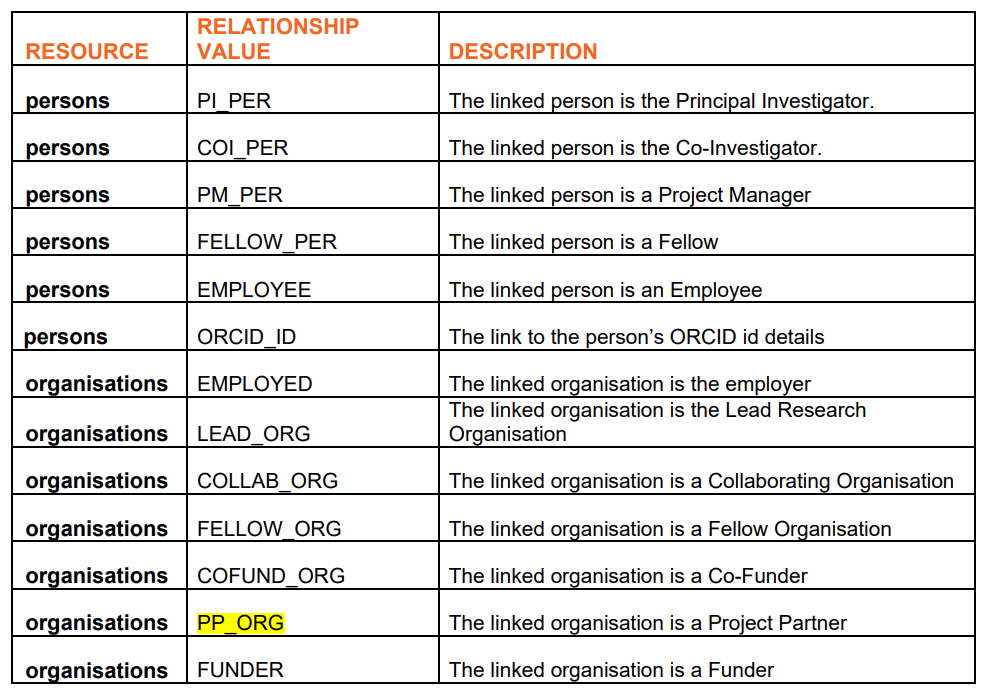

For each PROJECT associated with the organisation:
* New columns: from PI_PER "pi": {"name": "John Doe", "email": "} etc. 
  * Include employer to check same as base org. 
* New columns: from COI_PER's "colab_persons": [{"name": "John Doe", "email": "}]
* "lead_org"
* "colab_orgs"


Just do these for now, then once up and running, look at publications, and associated authors (IEEE API key)


Project Outputs:
* 'identifiers': {'identifier': [{'type': 'RCUK', 'value': 'ES/I028072/1'}]}    
  * Could lookup the probect on RCUK for more info? Likely already have it since we're using GtR
* 'leadOrganisationDepartment': 'Business School'
  * Is it useful to get the department info for the org of interest?
* 'links'
  * Another nested dictionary with lists of links, with href (link for api) and rel 
    * start with getting names: PI_PER and COI_PER
    * Check LEAD_ORG is same as parent org for the query. 
    * Get COLLAB_ORG as well. (may be multiple)
    * "KEY_FINDING" - Text could be useful for additional embedding data for a project (if not already included). 
      * Key_FINDING includes "description", "exploitationPathways", "sectors". "supportingURL" e.g. "https://www.agediversity.org/"
    * "PUBLICATION"
      * href e.g. http://gtr.ukri.org/gtr/api/outcomes/publications/5898EDEC-70B7-4970-AB8F-6260D1058A31
      * rel "PUBLICATION"
        * At href, we get:
          * title
          * publicationURL
          * date published
          * doi
          * author e.g. "Flynn M"
  
  EMPLOYEE outputs
    * person_details:
      * PM_PER (This person is the PI for the project in the list)
        * href: 'http://gtr.ukri.org/gtr/api/projects/1E0BB71C-795B-4D20-B46C-2E618CAC96C0
        * rel: PM_PER
      * Organisation (parent organisation)
        * href:http://gtr.ukri.org/gtr/api/organisations/5331B126-3AB4-4412-B56D-00E8F2796556'
        * rel: EMPLOYED
      * persons e.g http://gtr.ukri.org/gtr/api/persons/0CB4A538-AC14-4394-A10F-C9F955033EF3
        * fistName, otherNames, surname

```python
Processing org 5331B126-3AB4-4412-B56D-00E8F2796556, rel=EMPLOYEE
persons/0CB4A538-AC14-4394-A10F-C9F955033EF3
persons 0CB4A538-AC14-4394-A10F-C9F955033EF3
Fetching person details for person_id=0CB4A538-AC14-4394-A10F-C9F955033EF3, in domain=persons
{'created': 1720391292000,
 'email': None,
 'ext': None,
 'firstName': 'Lynne',
 'href': 'http://gtr.ukri.org/gtr/api/persons/0CB4A538-AC14-4394-A10F-C9F955033EF3',
 'id': '0CB4A538-AC14-4394-A10F-C9F955033EF3',
 'links': {'link': [{'end': None,
                     'href': 'http://gtr.ukri.org/gtr/api/projects/1E0BB71C-795B-4D20-B46C-2E618CAC96C0',
                     'otherAttributes': {},
                     'rel': 'PM_PER',
                     'start': None},
                    {'end': None,
                     'href': 'http://gtr.ukri.org/gtr/api/organisations/5331B126-3AB4-4412-B56D-00E8F2796556',
                     'otherAttributes': {},
                     'rel': 'EMPLOYED',
                     'start': None}]},
 'orcidId': None,
 'otherNames': '',
 'outcomeid': None,
 'surname': 'Davies',
 'updated': None}
 ```

In [34]:
# BASE_URL = "https://gtr.ukri.org/gtr/api"
# HEADERS = {
#     "Accept": "application/vnd.rcuk.gtr.json-v7"
# }

# def split_link(link):
#     """
#     Split link of form `http://gtr.ukri.org/gtr/api/<domain>/<id>` into domain and id.
#     """
#     base = "https://gtr.ukri.org/gtr/api"
#     tail = link[len(base):]
#     print(tail)
#     domain, identifier = tail.split("/")
#     print(domain, identifier)
#     return domain, identifier

# def create_async_client():
#     client = httpx.AsyncClient(
#         headers=HEADERS,
#         base_url=BASE_URL,
#         follow_redirects=True,
#         timeout=20
#     )   
#     return client

# async def fetch_data(client: httpx.AsyncClient, url: str) -> Dict[str, Any]:
#     """Fetch data from the GtR API."""
#     response = await client.get(url, headers=HEADERS)
#     response.raise_for_status()
#     return response.json()

# async def get_organization_details(client: httpx.AsyncClient, org_id: str) -> Dict[str, Any]:
#     """Fetch detailed information about an organization."""
#     url = f"{BASE_URL}/organisations/{org_id}"
#     return await fetch_data(client, url)

# async def get_project_details(client: httpx.AsyncClient, project_id: str) -> Dict[str, Any]:
#     """Fetch detailed information about a project."""
#     url = f"{BASE_URL}/projects/{project_id}"
#     return await fetch_data(client, url)

# async def get_person_details(client: httpx.AsyncClient, person_id: str) -> Dict[str, Any]:
#     """Fetch detailed information about a person."""
#     url = f"{BASE_URL}/persons/{person_id}"
#     return await fetch_data(client, url)

# async def enrich_organization_data(df: pd.DataFrame) -> pd.DataFrame:
#     """Enrich the organization data with additional information from the GtR API."""
#     async with httpx.AsyncClient() as client:
#         enriched_data = []
#         for _, row in df.iterrows():
#             org_id = row['id']
#             org_details = await get_organization_details(client, org_id)
            
#             # Fetch associated projects
#             projects = []
#             for link in org_details.get('links', []):
#                 if link['rel'] == 'PROJECT':
#                     project_id = link['href'].split('/')[-1]
#                     project_details = await get_project_details(client, project_id)
#                     projects.append(project_details)
            
#             # Fetch employee details
#             employees = []
#             for link in org_details.get('links', []):
#                 if link['rel'] == 'EMPLOYEE':
#                     person_id = link['href'].split('/')[-1]
#                     person_details = await get_person_details(client, person_id)
#                     employees.append(person_details)
            
#             enriched_data.append({
#                 'org_id': org_id,
#                 'org_name': org_details.get('name'),
#                 'org_address': org_details.get('address', {}).get('postCode'),
#                 'projects': projects,
#                 'employees': employees
#             })
        
#     return pd.DataFrame(enriched_data)

# split_link(df_id.iloc[0]["href_link"])

# # enriched_df = await enrich_organization_data(df_id)
# # enriched_df.head()
    

In [35]:
enriched_data

[{'org_id': '5331B126-3AB4-4412-B56D-00E8F2796556',
  'rel': 'PROJECT',
  'details': {'links': {'link': [{'href': 'http://gtr.ukri.org/gtr/api/persons/42FDE65C-3EDB-4494-AD0A-F31125B8C0A0',
      'rel': 'PI_PER',
      'start': None,
      'end': None,
      'otherAttributes': {}},
     {'href': 'http://gtr.ukri.org/gtr/api/persons/9E092DB5-1688-4C96-988D-FE9945730307',
      'rel': 'COI_PER',
      'start': None,
      'end': None,
      'otherAttributes': {}},
     {'href': 'http://gtr.ukri.org/gtr/api/organisations/AC11EAE6-D32A-4C68-B6BB-8059BE64FEF1',
      'rel': 'LEAD_ORG',
      'start': None,
      'end': None,
      'otherAttributes': {}},
     {'href': 'http://gtr.ukri.org/gtr/api/organisations/5331B126-3AB4-4412-B56D-00E8F2796556',
      'rel': 'COLLAB_ORG',
      'start': None,
      'end': None,
      'otherAttributes': {}},
     {'href': 'http://gtr.ukri.org/gtr/api/organisations/65DB5820-053E-436C-856D-86976BB40EE2',
      'rel': 'COLLAB_ORG',
      'start': None,
     

In [36]:
enriched

NameError: name 'enriched' is not defined

TypeError: string indices must be integers

In [8]:
# df_id.head()


help(Client)

Help on class Client in module httpx:

class Client(httpx._client.BaseClient)
 |  Client(*, auth: 'AuthTypes | None' = None, params: 'QueryParamTypes | None' = None, headers: 'HeaderTypes | None' = None, cookies: 'CookieTypes | None' = None, verify: 'VerifyTypes' = True, cert: 'CertTypes | None' = None, http1: 'bool' = True, http2: 'bool' = False, proxy: 'ProxyTypes | None' = None, proxies: 'ProxiesTypes | None' = None, mounts: 'None | typing.Mapping[str, BaseTransport | None]' = None, timeout: 'TimeoutTypes' = Timeout(timeout=5.0), follow_redirects: 'bool' = False, limits: 'Limits' = Limits(max_connections=100, max_keepalive_connections=20, keepalive_expiry=5.0), max_redirects: 'int' = 20, event_hooks: 'None | typing.Mapping[str, list[EventHook]]' = None, base_url: 'URL | str' = '', transport: 'BaseTransport | None' = None, app: 'typing.Callable[..., typing.Any] | None' = None, trust_env: 'bool' = True, default_encoding: 'str | typing.Callable[[bytes], str]' = 'utf-8') -> 'None'
 |  


In [12]:
help(AsyncClient)

Help on class AsyncClient in module httpx:

class AsyncClient(httpx._client.BaseClient)
 |  AsyncClient(*, auth: 'AuthTypes | None' = None, params: 'QueryParamTypes | None' = None, headers: 'HeaderTypes | None' = None, cookies: 'CookieTypes | None' = None, verify: 'VerifyTypes' = True, cert: 'CertTypes | None' = None, http1: 'bool' = True, http2: 'bool' = False, proxy: 'ProxyTypes | None' = None, proxies: 'ProxiesTypes | None' = None, mounts: 'None | typing.Mapping[str, AsyncBaseTransport | None]' = None, timeout: 'TimeoutTypes' = Timeout(timeout=5.0), follow_redirects: 'bool' = False, limits: 'Limits' = Limits(max_connections=100, max_keepalive_connections=20, keepalive_expiry=5.0), max_redirects: 'int' = 20, event_hooks: 'None | typing.Mapping[str, list[EventHook]]' = None, base_url: 'URL | str' = '', transport: 'AsyncBaseTransport | None' = None, app: 'typing.Callable[..., typing.Any] | None' = None, trust_env: 'bool' = True, default_encoding: 'str | typing.Callable[[bytes], str]' =

In [24]:
# get href_org  list
href_org = df["href_org"].tolist()[60:120]
print(href_org)

['http://gtr.ukri.org/gtr/api/organisations/53966061-8B83-46CE-A89B-0742392BBF28', 'http://gtr.ukri.org/gtr/api/organisations/53966061-8B83-46CE-A89B-0742392BBF28', 'http://gtr.ukri.org/gtr/api/organisations/53966061-8B83-46CE-A89B-0742392BBF28', 'http://gtr.ukri.org/gtr/api/organisations/5396B4CA-422A-4ACB-88AC-1BF02F1D28D3', 'http://gtr.ukri.org/gtr/api/organisations/53976912-3F5A-4744-95C5-064AB2C12A67', 'http://gtr.ukri.org/gtr/api/organisations/53976912-3F5A-4744-95C5-064AB2C12A67', 'http://gtr.ukri.org/gtr/api/organisations/53976912-3F5A-4744-95C5-064AB2C12A67', 'http://gtr.ukri.org/gtr/api/organisations/53976912-3F5A-4744-95C5-064AB2C12A67', 'http://gtr.ukri.org/gtr/api/organisations/53976912-3F5A-4744-95C5-064AB2C12A67', 'http://gtr.ukri.org/gtr/api/organisations/5398E19C-4A38-4777-9DB1-0224648914E0', 'http://gtr.ukri.org/gtr/api/organisations/5398E19C-4A38-4777-9DB1-0224648914E0', 'http://gtr.ukri.org/gtr/api/organisations/53A5E511-5AF1-4968-9003-017A4654CDDF', 'http://gtr.ukr

In [16]:
# get all href_links for "rel" = PROJECT
df_id_project = df_id[df_id["rel"] == "PROJECT"]
df_id_project.head()


,id,href_org,links,href_link,rel,start,end
0,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-...,PROJECT,NaN,NaN
1,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0D0F72CC-...,PROJECT,NaN,NaN
2,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/0C6849FD-...,PROJECT,NaN,NaN
3,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/C4059685-...,PROJECT,NaN,NaN
4,5331B126-3AB4-4412-B56D-00E8F2796556,http://gtr.ukri.org/gtr/api/organisations/5331...,{'href': 'http://gtr.ukri.org/gtr/api/projects...,http://gtr.ukri.org/gtr/api/projects/F0E04953-...,PROJECT,NaN,NaN


In [17]:
links = df_id_project["href_link"].to_list()
print(links)

['http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906', 'http://gtr.ukri.org/gtr/api/projects/0D0F72CC-0163-47CE-A462-5FDDBA4C1C38', 'http://gtr.ukri.org/gtr/api/projects/0C6849FD-CA2D-49A9-80D4-75F710980208', 'http://gtr.ukri.org/gtr/api/projects/C4059685-9263-44E6-B89A-D8609FCC1360', 'http://gtr.ukri.org/gtr/api/projects/F0E04953-58F2-46FB-9837-3C341A3D3165', 'http://gtr.ukri.org/gtr/api/projects/D9A401D9-6D91-4DA6-9012-7137774B1DD8', 'http://gtr.ukri.org/gtr/api/projects/EC918CE3-4862-4EED-884A-E1AC42C8F46D', 'http://gtr.ukri.org/gtr/api/projects/ADB18319-E0B8-4735-AC8B-59946A4BB9CB', 'http://gtr.ukri.org/gtr/api/projects/DCFE5B2E-2EC2-4AA2-9244-EE252CED60E4', 'http://gtr.ukri.org/gtr/api/projects/1E0BB71C-795B-4D20-B46C-2E618CAC96C0', 'http://gtr.ukri.org/gtr/api/projects/2294E699-BBAC-47CB-9293-6BAC6BED2640', 'http://gtr.ukri.org/gtr/api/projects/A45E2042-8FFF-40EF-B270-15D95481946E', 'http://gtr.ukri.org/gtr/api/projects/096F035D-FAEB-4187-9C63-1DA5337E85B9'

In [18]:
def get_end_of_link(link):
    # convert links like 'http://gtr.ukri.org/gtr/api/projects/E0B948B2-4771-4063-BCF0-2E0B58080049', 
    # to 'E0B948B2-4771-4063-BCF0-2E0B58080049'
    return link.split("/")[-1]
print(get_end_of_link(links[0]))

0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906


Use guide https://gtr.ukri.org/resources/GtR-2-API-v1.7.4.pdf

and api_v2_scraper_outcomes.ipynb

Can use xlm or json in headers{"accept": ...}
* application/vnd.rcuk.gtr.xml-v7
* application/vnd.rcuk.gtr.json-v7

In [19]:
httpx = Client(
    headers={"accept": "application/vnd.rcuk.gtr.json-v7"},
    base_url="http://gtr.ukri.org/gtr/api/projects",
    follow_redirects=True,
    timeout=30,
)

domains =[
    {"url": "publications", "key": "publication"},
]
ENDPOINT = domains[0]


for link in links:
    link = get_end_of_link(link)
    result = httpx.get(link).json()
    pprint(result)



{'abstractText': 'Abstracts are not currently available in GtR for all funded '
                 'research. This is normally because the abstract was not '
                 'required at the time of proposal submission, but may be '
                 'because it included sensitive information such as personal '
                 'details.',
 'created': 1720391293000,
 'end': None,
 'ext': None,
 'grantCategory': 'Research Grant',
 'healthCategories': {'healthCategory': []},
 'href': 'http://gtr.ukri.org/gtr/api/projects/0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906',
 'id': '0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906',
 'identifiers': {'identifier': [{'type': 'RCUK', 'value': 'ES/I028072/1'}]},
 'leadFunder': 'ESRC',
 'leadOrganisationDepartment': 'Business School',
 'links': {'link': [{'end': None,
                     'href': 'http://gtr.ukri.org/gtr/api/persons/42FDE65C-3EDB-4494-AD0A-F31125B8C0A0',
                     'otherAttributes': {},
                     'rel': 'PI_PER',
                    

next, go to publication link and get author, or check for authors in the project link

In [20]:
result = httpx.get("0D5DF2FF-B732-4218-B0E3-4FFBF3DDC906").json()

In [21]:
result

{'links': {'link': [{'href': 'http://gtr.ukri.org/gtr/api/persons/42FDE65C-3EDB-4494-AD0A-F31125B8C0A0',
    'rel': 'PI_PER',
    'start': None,
    'end': None,
    'otherAttributes': {}},
   {'href': 'http://gtr.ukri.org/gtr/api/persons/9E092DB5-1688-4C96-988D-FE9945730307',
    'rel': 'COI_PER',
    'start': None,
    'end': None,
    'otherAttributes': {}},
   {'href': 'http://gtr.ukri.org/gtr/api/organisations/AC11EAE6-D32A-4C68-B6BB-8059BE64FEF1',
    'rel': 'LEAD_ORG',
    'start': None,
    'end': None,
    'otherAttributes': {}},
   {'href': 'http://gtr.ukri.org/gtr/api/organisations/5331B126-3AB4-4412-B56D-00E8F2796556',
    'rel': 'COLLAB_ORG',
    'start': None,
    'end': None,
    'otherAttributes': {}},
   {'href': 'http://gtr.ukri.org/gtr/api/organisations/65DB5820-053E-436C-856D-86976BB40EE2',
    'rel': 'COLLAB_ORG',
    'start': None,
    'end': None,
    'otherAttributes': {}},
   {'href': 'http://gtr.ukri.org/gtr/api/funds/8963E2CF-21E3-42BC-9068-8DB325F62AA5',
   